In [1]:
import sys
from os import path
import os
from dotenv import load_dotenv

load_dotenv()
sys.path.append(path.dirname(os.getcwd()))

hf_token = os.environ["HUGGING_FACE_API_KEY"]


In [2]:
import json
import pandas as pd
from project.models import YouTubeVideoInfo

with open("../data/myyounicon-01/videos_infos.json", "r") as json_file:
    videos = [YouTubeVideoInfo.from_json(v) for v in json.load(json_file)]

labels = pd.read_csv("../data/YouNiCon/conspiracy_label.csv")
labels = labels[labels["video_id"].isin([v.id for v in videos])]
conspiracy_videos = labels[labels["majority_label"] == 1] 
non_conspiracy_videos = labels[labels["majority_label"] == 0] 

print(f"Total instances: {len(labels)}, conspiracy instances: {len(conspiracy_videos)}, non conspiracy instances: {len(non_conspiracy_videos)}")

Total instances: 2515, conspiracy instances: 897, non conspiracy instances: 1618


In [3]:
print(videos[1].to_string_for_model_input(["channel_title", "title", "description", "tags", "auto_subtitles", "comments", "subtitles"], -1, 1000, 5, True))

**channel_title**: Messianic Torah Follower of yeshua HaMashiach

**title**: Protect Yourself From Fake Cell Towers, Silent SMS, & Stingrays 2018 Cell Spy Catcher Anti Spy Andro

**description**: Cell Spy Catcher (Anti Spy) https://play.google.com/store/apps/details?id=com.skibapps.cellspycatcher&hl=en_US 
 How stingrays work https://youtu.be/wzSgLpNrr2E
#1 Check out http://ChristianitatisCuria.com !
#2 How to Build and License Your own Motorized Bicycle http://HowToBuildAMoped.com/
BUY PARTS http://www.bikeberry.com?acc=8ce241e1ed84937ee48322b170b9b18c
#3 Get Protection In Court After You Defend Yourself and Others https://tracking.deltadefense.com/SH1xX
#4 How to Win in Court https://www.howtowinincourt.com?refercode=BJ0089
#5 How To Get more Subscribers On YouTube Fast Hack https://youtube-promos.com/unboxing_authority
#6 How to Be 100% Anonymous Online https://billing.purevpn.com/aff.php?aff=33638 https://www.youtube.com/watch?v=T5Ef1mi4gx4 & Complete Tutorial https://www.youtube.c

## Multimodal Models

In [3]:
import base64

def load_image_data_in_chat_format(video_id: str, image_filename_format: str):
    image_path = f"/home/leoli/Uni/Polimi/Thesis/master-thesis/data/myyounicon-01/images/{image_filename_format}".format(video_id)
    print(image_path)
    with open(image_path, "rb") as f:
        return {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64.b64encode(f.read()).decode('utf-8')}"}}



In [6]:
from huggingface_hub import InferenceClient
from project.llm_models import prompts
from project.experiments.models import Experiment
from datetime import datetime, timezone
import time


hf = InferenceClient(token=hf_token)

description = "Simple prompt and images to multimodal llama 3.2 11B model. The model accepts only one image per input so we provide the thumbnail. The model has a context window of 128k but the inferece api limits the input tokens to 4096, thus we truncate the max comments number to 5 to avoid exceeding the limit."
experiment_id = str(round(time.time()))
start_time = datetime.now(timezone.utc)

models = ["meta-llama/Llama-3.2-11B-Vision-Instruct"]
system_roles = ["system"]
system_prompt =  prompts.tiktok_paper_simple_prompt_with_images()
attributes = ["channel_title", "title", "description", "categories", "tags", "subtitles", "auto_subtitles", "comments"]
attributes_settings = {
    "max_description_length": -1,
    "max_subtitles_length": 1000, 
    "max_comments": 5,
    "include_comments_replies": True,
}
image_filename_format = "{}_thumbnail.jpg"

completions_by_model = {}

for model, system_role in zip(models, system_roles):
    completions_by_model[model] = {}
    for i, video in enumerate(videos[:1]):
        print(f"Processing video {i + 1}/{len(videos)} id: {video.id} ⚙️")

        user_prompt = video.to_string_for_model_input(attributes_to_include=attributes, **attributes_settings)

        messages = [
            {
                "role": system_role,
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text" : user_prompt},
                    load_image_data_in_chat_format(video.id, image_filename_format),
                ]
            },
        ]
        try:
            completion = hf.chat.completions.create(
                model=model, 
                messages=messages, 
            )
        except Exception as exception:
            completion = str(exception)
            print(completion)
            
        completions_by_model[model][video.id] = completion

end_time = datetime.now(timezone.utc)


Processing video 1/2515 id: -8u-hsE87xw ⚙️
/home/leoli/Uni/Polimi/Thesis/master-thesis/data/myyounicon-01/images/-8u-hsE87xw_thumbnail.jpg


In [7]:
print(completions_by_model)

{'meta-llama/Llama-3.2-11B-Vision-Instruct': {'-8u-hsE87xw': ChatCompletionOutput(choices=[ChatCompletionOutputComplete(finish_reason='stop', index=0, message=ChatCompletionOutputMessage(role='assistant', content='1', tool_calls=None), logprobs=None)], created=1734537888, id='', model='meta-llama/Llama-3.2-11B-Vision-Instruct', system_fingerprint='2.4.1-sha-d2ed52f', usage=ChatCompletionOutputUsage(completion_tokens=2, prompt_tokens=1938, total_tokens=1940))}}


In [5]:
import json
from project.utils.json_utils import EnhancedJSONEncoder
from project.experiments.models import Experiment

experiment = Experiment.from_completions(
    attributes_settings=attributes_settings,
    attributes=attributes,
    completions_by_model=completions_by_model,
    description=description,
    end_time=end_time,
    id=experiment_id,
    image_filename_format=image_filename_format,
    models=models,
    start_time=start_time,
    system_prompt=system_prompt,
)

with open(f"experiment-{experiment_id}.json", "w") as f:
    json.dump(experiment, f, cls=EnhancedJSONEncoder)

    

In [ ]:
# TMP: read predicted labels
import json

with open(f"{model.replace("/", "-")}-predicted_labels.json", "r") as f:
    predicted_labels_dic = json.load(f)

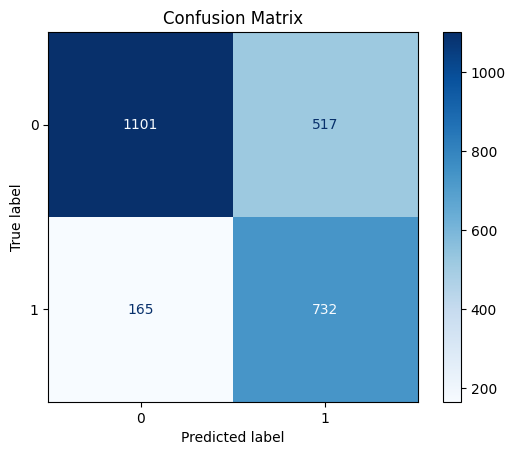

              precision    recall  f1-score   support

           0       0.87      0.68      0.76      1618
           1       0.59      0.82      0.68       897

    accuracy                           0.73      2515
   macro avg       0.73      0.75      0.72      2515
weighted avg       0.77      0.73      0.73      2515



In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

video_ids = sorted([video.id for video in videos])
true_labels = labels.set_index("video_id").loc[video_ids, "majority_label"].tolist()
predicted_labels = [predicted_labels_dic[id] for id in video_ids]

conf_matrix = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["0", "1"])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, predicted_labels))

## Multimodal Models